In [33]:
import gym
import torch
from torch import nn #needed for building neural networks
import torch.nn.functional as F #needed for activation functions
import torch.optim as opt #needed for optimisation
import random
from copy import copy, deepcopy
from collections import deque
import numpy as np
print("Using torch version: {}".format(torch.__version__))

Using torch version: 1.4.0


## Gym 환경 
### Pendulum 환경 불러오기

In [34]:
env_name = "Pendulum-v0"
env = gym.make(env_name)

환경의 state_dim과 action_dim을 불러오기
- Network 의 input dimension과 output dimension을 결정하기 위함

In [35]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action space의 boundary 체크

In [36]:
action_low = env.action_space.low
action_high = env.action_space.high

In [37]:
action_low, action_high

(array([-2.], dtype=float32), array([2.], dtype=float32))

# Main running code with random action

In [39]:
initial_state = env.reset()
  
while True:
    env.render()
    action =  np.random.uniform(low=action_low, high=action_high)
    state_next, reward, done, info = env.step(action)

    if done:
        break
env.close()

Note: pendulum 환경은 rendering이 있지만 우리가 사용할 환경에는 render option이 없습니다

## Build Neural Network 
Actor : state를 기반으로 action을 만들어주는 네트워크
- input dim : dimension of state
- output dim : dimension of action

Critic : state와 action을 기반으로 가치를 평가해주는 네트워크
- input dim : dimension of state + dimension of action
- output dim : 1

In [40]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64]):
        super(Actor, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        input_dims = [state_dim] + hidden_dim
        output_dims = hidden_dim + [action_dim]

        for in_dim, out_dim in zip(input_dims, output_dims):
            self.layers.append(nn.Linear(in_dim, out_dim))

        for i in range(len(hidden_dim)):
            self.activations.append(nn.LeakyReLU())

        self.activations.append(nn.Tanh())

    def forward(self, state):
        x = state
        for l, activation in zip(self.layers, self.activations):
            x = l(x)
            x = activation(x)
        return x

In [41]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64], output_dim=1):
        super(Critic, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        input_dims = [state_dim + action_dim] + hidden_dim
        output_dims = hidden_dim + [output_dim]

        for in_dim, out_dim in zip(input_dims, output_dims):
            self.layers.append(nn.Linear(in_dim, out_dim))

        for i in range(len(hidden_dim)):
            self.activations.append(nn.LeakyReLU())

        self.activations.append(nn.Identity())

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        for l, act in zip(self.layers, self.activations):
            x = l(x)
            x = act(x)

        return x

## Update Target Network 

## Target Network를 두는 이유와 update 하는 방법에 대한 수식 추가##



In [42]:
def update_model(source, target, tau):
    for src_param, target_param in zip(source.parameters(), target.parameters()):
        target_param.data.copy_(tau * src_param.data + (1.0 - tau) * target_param.data)

# Replay Memory

state transition:  $(s, a, r, s', terminal)$ 을 저장

In [43]:
class ReplayMemory:
    def __init__(self, length):
        self.memory = deque(maxlen=length)

    def __len__(self):
        return len(self.memory)

    def save_memory(self, transition):
        self.memory.append(transition)

    def sample(self, size):
        sample = random.sample(self.memory, size)

        state = [i[0] for i in sample]
        action = [i[1] for i in sample]
        reward = [i[2] for i in sample]
        next_state = [i[3] for i in sample]
        terminal = [i[4] for i in sample]

        state = np.stack(state)
        state = torch.Tensor(state).squeeze()

        next_state = np.stack(next_state)
        next_state = torch.Tensor(next_state).squeeze()

        reward = np.array(reward)
        reward = torch.tensor(reward, dtype=torch.float32).reshape(-1, 1)

        terminal = np.array(terminal).astype(int)
        terminal = torch.tensor(terminal).reshape(-1, 1)

        action = np.array(action)
        action = torch.tensor(action, dtype=torch.float32)

        return state, action, reward, next_state, terminal

# OU process

- 시간과 correlated 된 noise를 주기 위해서 OU process를 이용
- noise를 통해서 exploration을 진행

In [44]:
class OUNoise:
    """
    Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
    """

    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=1000):
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_space
        self.reset()

        self.epsilon = 1.0
        self.epsilon_decay = 0.00001
        self.epsilon_min = 0.05

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state() * self.epsilon

        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min

        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, -1.0, 1.0)

## Build Agent - Agent 에 포함되어야 하는 함수들
#### 1. get_action
* input: state
* output: action

    state를 받아서 actor을 통과시켜 action을 return하는 함수
    
#### 2. save_transition
* input: (s, a, r, s', terminal)

    memory에 transition을 저장하는 함수
    
#### 3. train_start
* output: True or False

    memory size가 batch size보다 커서 학습을 시작할 수 있는지 체크하는 함수

#### 4. fit
* output : critic loss, actor loss

    actor와 critic을 학습하는 함수

In [45]:
class DDPGAgent(nn.Module):
    def __init__(self, state_dim, action_dim, action_min, action_max, gamma=0.99):
        super(DDPGAgent, self).__init__()
        self.action_min = np.array(action_min)
        self.action_max = np.array(action_max)

        self.gamma = gamma
        self.ou_noise = OUNoise(action_dim)

        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)

        self.actor_target = Actor(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)

        update_model(self.actor, self.actor_target, tau=1.0)
        update_model(self.critic, self.critic_target, tau=1.0)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.memory = ReplayMemory(5000)
        self.batch_size = 50
        self.tau = 0.005

        self.loss_ftn = nn.MSELoss()

    def get_action(self, state, t=0):
        action_before_norm = self.actor(state).detach().numpy()
        action_before_norm = self.ou_noise.get_action(action_before_norm, t)

        action_after_norm = (action_before_norm + 1) / 2 * (self.action_max - self.action_min) + self.action_min

        return action_before_norm, action_after_norm

    def save_transition(self, transition):
        self.memory.save_memory(transition)

    def train_start(self):
        return len(self.memory) > self.batch_size

    def fit(self):
        state, action, reward, next_state, terminal = self.memory.sample(self.batch_size)

        next_q_val = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + self.gamma * (1 - terminal) * next_q_val
        q = self.critic(state, action)

        # Critic loss
        value_loss = self.loss_ftn(q, target_q)

        # Critic update
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        policy_loss = -self.critic(state, self.actor(state))
        policy_loss = policy_loss.mean()

        # Actor update
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        update_model(self.critic, self.critic_target, tau=self.tau)
        update_model(self.actor, self.actor_target, tau=self.tau)

        return value_loss.item(), policy_loss.item()

## 이제 Agent를 학습시켜볼까요?

In [46]:
# 환경과 Agent 민들기
env_name = "Pendulum-v0"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action_low = env.action_space.low
action_high = env.action_space.high

agent = DDPGAgent(state_dim, action_dim, action_low, action_high)

# 환경 변수
MAX_EPISODES = 1300

# Performance metric
rewards = []
critic_loss_traj = []
actor_loss_traj = []

for e in range(MAX_EPISODES):

    state = env.reset()
    episode_reward = 0
    step = 0
    critic_loss_epi = []
    actor_loss_epi = []

    while True:

        state_input = torch.tensor(state, dtype=torch.float32)
        action, action_norm = agent.get_action(state_input, step)

        next_state, reward, done, info = env.step(action_norm)

        transition = [state, action, reward, next_state, done]
        agent.save_transition(transition)

        state = next_state
        episode_reward += reward

        if agent.train_start():
            critic_loss, actor_loss = agent.fit()
            
            critic_loss_epi.append(critic_loss)
            actor_loss_epi.append(actor_loss)
            
        if done:
            rewards.append(episode_reward)
            critic_loss_traj += critic_loss_epi
            actor_loss_traj += actor_loss_epi
            
            critic_mean = sum(critic_loss_epi) / len(critic_loss_epi)
            actor_mean = sum(actor_loss_epi) / len(actor_loss_epi)
            
            print("episode : %4d, reward : % 4.3f, critic loss : %4.3f, actor loss : %4.3f" % (e, rewards[-1], critic_mean, actor_mean))
            break

        step += 1

episode :    0, reward : -1192.472, critic loss : 15.142, actor loss : 5.422
episode :    1, reward : -1732.829, critic loss : 1.013, actor loss : 10.346
episode :    2, reward : -1532.807, critic loss : 0.616, actor loss : 16.071
episode :    3, reward : -1535.462, critic loss : 1.147, actor loss : 22.224
episode :    4, reward : -1410.251, critic loss : 1.896, actor loss : 28.081
episode :    5, reward : -1619.620, critic loss : 3.772, actor loss : 34.461
episode :    6, reward : -1449.244, critic loss : 4.306, actor loss : 41.124
episode :    7, reward : -1539.590, critic loss : 7.890, actor loss : 47.370
episode :    8, reward : -1490.110, critic loss : 12.624, actor loss : 53.277
episode :    9, reward : -1407.200, critic loss : 17.348, actor loss : 59.129
episode :   10, reward : -1448.504, critic loss : 20.677, actor loss : 64.546
episode :   11, reward : -1284.095, critic loss : 25.474, actor loss : 69.832
episode :   12, reward : -1375.640, critic loss : 27.162, actor loss : 7

KeyboardInterrupt: 

## 학습 되었는지 확인하기 1
- reward, critic loss, actor loss를 그려서 학습이 잘 되었는지 확인해 봅시다!

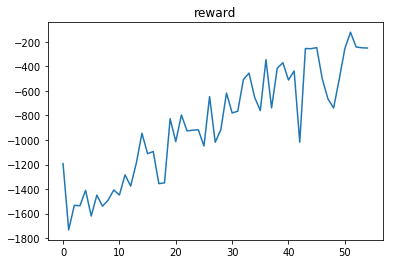

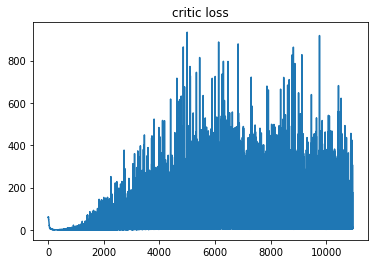

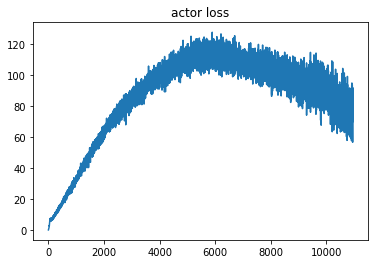

In [47]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title('reward')
plt.show()

plt.plot(critic_loss_traj)
plt.title('critic loss')
plt.show()

plt.plot(actor_loss_traj)
plt.title('actor loss')
plt.show()

## 학습 되었는지 확인하기 2
- 학습된 policy를 render 해보면서 잘 학습되었는지 확인해 봅시다!

In [48]:
state = env.reset()

while True:
    
    env.render()

    state_input = torch.tensor(state, dtype=torch.float32)
    
    _, action_norm = agent.get_action(state_input)

    state, _, done, _ = env.step(action_norm)

    if done:
        break

env.close()